In [3]:
import torch
import pandas as pd
import numpy as np
import yaml
import importlib
import sys
import os
import matplotlib.pyplot as plt
import glob
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
stf_dir = os.path.join(os.pardir, 'spacetimeformer')

sys.path.append(stf_dir)


import spacetimeformer as stf
importlib.reload(stf) #to make sure the last version of stf is used

from torch.distributions import Normal
import pickle

In [4]:
os.listdir("..\\spacetimeformer\\spacetimeformer\\data\\stf_LOG_DIR\\wandb\\")

['run-20220309_144454-tq5nzspb',
 'run-20220309_145450-3nzjwnv9',
 'run-20220309_160528-dncdoo7o',
 'run-20220309_162332-1wvm6y6m',
 'run-20220309_162357-142148s6',
 'run-20220309_163828-1p01uoj3',
 'run-20220309_175332-1zbkkp2a',
 'run-20220309_175357-16nfo94h',
 'run-20220309_180329-3foofrtb',
 'run-20220310_133006-gxxfap3n',
 'run-20220310_134344-2wrqohoq',
 'run-20220311_143155-1qph7vgp',
 'run-20220311_143213-3camjv6f',
 'run-20220311_143924-3asnwyy9',
 'run-20220311_144132-3fwfsn6w',
 'run-20220311_145607-3ficlwez',
 'run-20220311_171546-3gxv9qle',
 'run-20220311_174834-ym4uvfpv',
 'run-20220311_174915-3pwi5dx8',
 'run-20220311_175054-32lr4vqw',
 'run-20220314_090524-14ssgdk9',
 'run-20220314_092703-2vahwf14',
 'run-20220314_092732-1uhy3tbv',
 'run-20220314_092812-156pzr5x',
 'run-20220314_132645-2tdi8anz',
 'run-20220314_132715-1vlskdzo',
 'run-20220315_103112-3nbf1la4',
 'run-20220315_103139-2kfujejz',
 'run-20220315_105704-26gojq82',
 'run-20220315_110033-6g39nco2',
 'run-2022

In [5]:
#run_name = 'run-20220314_090524-14ssgdk9'   #best lstm small sweep lf
#run_name = 'run-20220321_090744-2p2j5rkr'   #best lstm full sweep hf
#run_name = 'run-20220317_112731-1aygoe3p'   #linear baseline, full hf
#run_name = 'run-20220317_184316-gt3bk7k2'   #linear baseline, full lf
#run_name = 'run-20220321_154833-b86d3c1b'   #lstm sample, small hf, tr 1
#run_name = 'run-20220328_180251-1dh63g4v'   #best lstm small sweep hf
#run_name = 'run-20220328_095331-3m2bcyh4'    #stf full hf
#run_name = 'run-20220404_142713-266d18o0'    #best lstm small sweep hf regularition + weighted loss
#run_name = 'run-20220404_163755-2no2l4qy'
run_name = 'run-20220405_093057-1msb80nc' #best sweep clusters
#run_name = 'run-20220406_143629-g48bfvzg'  #linear hr 1day
#run_name = 'run-20220406_154643-263zff1a'  #linear lr 15 days
#run_name = 'run-20220406_165431-uumzxgp5'  #linear lr 1day
config_path = "..\\spacetimeformer\\spacetimeformer\\data\\stf_LOG_DIR\\wandb\\" + run_name+"\\files\\config.yaml"
with open(config_path) as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    config = yaml.load(file, Loader=yaml.FullLoader)
config_pross = {}
for key in config:
    try:
        config_pross[key]=config[key]['value']
    except:
        config_pross[key]=config[key]
config=config_pross
print("run name: "+config['run_name'])
print("model used: "+config['model'])
print("dataset used: "+config['dset'])

run name: rerun_best_clusters
model used: lstm
dataset used: cluster_HF_int


In [238]:
#build the dset
if config['dset'] =='AquaCTD':
    data_path = config['data_path']
    date_format = "%d-%m-%Y"
    if data_path == 'auto':
        data_path = "../Datasets/Forecasting_Aqua/ctd_meteo_aua_2019to2021_V2.csv"
    df = pd.read_csv(data_path)
    target_cols = ['mean_chla']
    target_cols+=list(df.keys().drop(['Datetime','mean_chla']))
    NULL_VAL = 0.
if config['dset']=='small_aqua':
    data_path = config['data_path']
    date_format = "%d/%m/%Y"
    if data_path == 'auto':
        data_path = "../Datasets/Forecasting_Aqua/ctd_meteo_aua_2019to2021_small_V2.csv"
    df = pd.read_csv(data_path)
    target_cols = ['mean_chla']
    target_cols+=list(df.keys().drop(['Datetime','mean_chla']))
    NULL_VAL = 0.
if config['dset']=='vsmall_aqua':
    data_path = config['data_path']
    date_format = "%d/%m/%Y"
    if data_path == 'auto':
        data_path = "../Datasets/Forecasting_Aqua/ctd_meteo_aua_2019to2021_vsmall_toy.csv"
    df = pd.read_csv(data_path)
    target_cols = []
    target_cols+=list(df.keys().drop(['Datetime']))
    NULL_VAL = 0.
if config['dset'] =='HF_int':
        data_path = config['data_path']
        date_format = "%Y-%m-%d %H:%M:%S"
        if data_path == 'auto':
            data_path = "../Datasets/Forecasting_Aqua/data_h_rolling_interpolated.csv"
        df = pd.read_csv(data_path)
        target_cols = ['mean_chla_depth']
        target_cols+=list(df.keys().drop(['Datetime','mean_chla_depth']))
        NULL_VAL = 0.
if config['dset'] =='HF_noint':
        data_path = config['data_path']
        date_format = "%Y-%m-%d %H:%M:%S"
        if data_path == 'auto':
            data_path = "../Datasets/Forecasting_Aqua/data_h_rolling.csv"
        df = pd.read_csv(data_path)
        target_cols = ['mean_chla_depth']
        target_cols+=list(df.keys().drop(['Datetime','mean_chla_depth']))
        NULL_VAL = 0.
if 'small_HF' in config['dset']:
        data_path = config['data_path']
        date_format = "%d/%m/%Y %H:%M"
        if data_path == 'auto':
            if config['dset'] == 'small_HF_int':
                data_path = "../Datasets/Forecasting_Aqua/data_h_rolling_interpolated_small.csv"
            elif config['dset'] == 'small_HF_noint':
                data_path = "../Datasets/Forecasting_Aqua/data_h_rolling_small.csv"
        df = pd.read_csv(data_path)
        target_cols = ['mean_chla_depth']
        target_cols+=list(df.keys().drop(['Datetime','mean_chla_depth']))
        NULL_VAL = 0.  
if 'cluster_HF' in config['dset']:
    data_path = config['data_path']
    date_format = "%d/%m/%Y %H:%M"
    if data_path == 'auto':
        if config['dset'] == 'cluster_HF_int':
            data_path = "../Datasets/Forecasting_Aqua/data_h_rolling_interpolated_clusters.csv"
        elif config['dset'] == 'cluster_HF_noint':
            data_path = "../Datasets/Forecasting_Aqua/data_h_rolling_clusters.csv"
    df = pd.read_csv(data_path)
    target_cols = ['mean_chla_depth']
    target_cols+=list(df.keys().drop(['Datetime','mean_chla_depth']))
    NULL_VAL = 0.  

dset = stf.data.CSVTimeSeries(
    data_path=data_path,
    target_cols=target_cols,
    date_format = date_format,
    nanval = NULL_VAL,
)

x_dim = 4 if 'HF' in config['dset'] else 3
y_dim = len(target_cols)
loss_w = torch.zeros(y_dim)
loss_w[0] = 1
loss_w /=loss_w.sum()

#build the model
if config['model'] =='spacetimeformer':
    forecaster = stf.spacetimeformer_model.Spacetimeformer_Forecaster(
            d_y=y_dim,
            d_x=x_dim,
            start_token_len=config['start_token_len'],
            attn_factor=config['attn_factor'],
            d_model=config['d_model'],
            n_heads=config['n_heads'],
            e_layers=config['enc_layers'],
            d_layers=config['dec_layers'],
            d_ff=config['d_ff'],
            dropout_emb=config['dropout_emb'],
            dropout_token=config['dropout_token'],
            dropout_attn_out=config['dropout_attn_out'],
            dropout_qkv=config['dropout_qkv'],
            dropout_ff=config['dropout_ff'],
            global_self_attn=config['global_self_attn'],
            local_self_attn=config['local_self_attn'],
            global_cross_attn=config['global_cross_attn'],
            local_cross_attn=config['local_cross_attn'],
            performer_kernel=config['performer_kernel'],
            performer_redraw_interval=config['performer_redraw_interval'],
            post_norm=config['post_norm'],
            norm=config['norm'],
            activation=config['activation'],
            init_lr=config['init_lr'],
            base_lr=config['base_lr'],
            warmup_steps=config['warmup_steps'],
            decay_factor=config['decay_factor'],
            initial_downsample_convs=config['initial_downsample_convs'],
            intermediate_downsample_convs=config['intermediate_downsample_convs'],
            embed_method=config['embed_method'],
            l2_coeff=config['l2_coeff'],
            loss=config['loss'],
            linear_window=config['linear_window'],
            class_loss_imp=config['class_loss_imp'],
            time_emb_dim=config['time_emb_dim'],
            loss_weight= loss_w
        )
elif config['model'] == "lstm":
    forecaster = stf.lstm_model.LSTM_Forecaster(
        # encoder
        d_x=x_dim,
        d_y=y_dim,
        time_emb_dim=config['time_emb_dim'],
        hidden_dim=config['hidden_dim'],
        n_layers=config['n_layers'],
        dropout_p=config['dropout_p'],
        # training
        learning_rate=config['learning_rate'],
        teacher_forcing_prob=config['teacher_forcing_start'],
        l2_coeff=config['l2_coeff'],
        loss=config['loss'],
        linear_window=config['linear_window'],
    )
elif config['model']=='linear':
    forecaster = stf.linear_model.Linear_Forecaster(
        context_points=config['context_points'],
        learning_rate=config['learning_rate'],
        l2_coeff=config['l2_coeff'],
        loss=config['loss'],
        linear_window=config['linear_window'],
    )
elif config['model']=='linear_sep':
    forecaster = stf.linear_model.Linear_sep_Forecaster(
        d_y = y_dim,
        context_points=config['context_points'],
        learning_rate=config['learning_rate'],
        l2_coeff=config['l2_coeff'],
        loss=config['loss'],
        linear_window=config['linear_window'],
        dropout=config['dropout_p']
    )
else:
    print(f"{config['model']} model not implemented")


In [239]:
#load the checkpoints
checkpoints_dir = "..\\spacetimeformer\\data\\stf_model_checkpoints\\"
run_name = config['run_name']
salt = ""

checkpoints = glob.glob(checkpoints_dir+run_name+"_"+salt+"*\\*\\*",recursive=True)
if len(checkpoints)>1:
    print("please add a part of the random number so there is only one result")
checkpoint = checkpoints[0]
checkpoints

['..\\spacetimeformer\\data\\stf_model_checkpoints\\linear_sep_lr_1day1day_dr02_654019012\\linear_sep_lr_1day1day_dr02epoch=66-val\\loss=1.09.ckpt']

In [240]:
forecaster.load_state_dict(torch.load(checkpoint)['state_dict'],strict=True)

<All keys matched successfully>

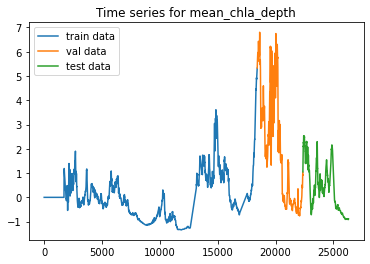

In [241]:
key = 'mean_chla_depth'
y_train = dset.train_data[key]
y_val = dset.val_data[key]
y_test = dset.test_data[key]
plt.plot(dset.train_data.index,y_train)
plt.plot(dset.val_data.index,y_val)
plt.plot(dset.test_data.index,y_test)
plt.title(f"Time series for {key}")
plt.legend(["train data","val data","test data"])
plt.show()

In [242]:
#format the dataset into x and y:
x_train = (dset.train_data[['Day','Month','Year','Hour']] if 'HF' in config['dset'] 
           else dset.train_data[['Day','Month','Year']])
y_train = dset.train_data[target_cols]

x_val = (dset.val_data[['Day','Month','Year','Hour']] if 'HF' in config['dset'] 
        else dset.val_data[['Day','Month','Year']])
y_val = dset.val_data[target_cols]

x_test = (dset.test_data[['Day','Month','Year','Hour']] if 'HF' in config['dset'] 
          else dset.test_data[['Day','Month','Year']])
y_test = dset.test_data[target_cols]

In [243]:
idx = 0
ctx = config['context_points']
trg = config['target_points']
x = torch.tensor(x_train.values,dtype=torch.float32)
y = torch.tensor(y_train.values,dtype=torch.float32)
res_idx,*class_res=forecaster(x[idx:idx+ctx].unsqueeze(0),
                              y[idx:idx+ctx].unsqueeze(0),
                              x[idx+ctx:idx+ctx+trg].unsqueeze(0),
                              y[idx+ctx:idx+ctx+trg].unsqueeze(0),
                      **forecaster.eval_step_forward_kwargs)

In [244]:
if isinstance(res_idx,torch.distributions.Normal):
    plt.plot(range(config['context_points'],config['context_points']+config['target_points']),
             res_idx.loc[0,:,0].detach().numpy())
    plt.plot(range(config['context_points'],config['context_points']+config['target_points']),
             res_idx.loc[1,:,0].detach().numpy())
    plt.plot(range(config['context_points']),res_idx.loc[2,:,0].detach().numpy())

In [245]:
#predict all results
res = {}
true = {}
ctx = config['context_points']
trg = config['target_points']
time_res = config['time_resolution']
for x,y,split in [(x_train,y_train,'train'),(x_val,y_val,'val'),(x_test,y_test,'test')]:
    x = torch.tensor(x.values,dtype=torch.float32)
    y = torch.tensor(y.values,dtype=torch.float32)
    res[split]=[]
    true[split]=[]
    print(f"split: {split}      ")
    for idx in range(len(x)-(ctx+trg)*time_res):
        print(f"{idx}/{len(x)-(ctx+trg)*time_res-1}",end='\r')
        with torch.no_grad():

            res_idx,*class_res=forecaster(x[idx:idx+ctx*time_res:time_res].unsqueeze(0),
                                          y[idx:idx+ctx*time_res:time_res].unsqueeze(0),
                                          x[idx+(1+ctx)*time_res:idx+(1+ctx+trg)*time_res:time_res].unsqueeze(0),
                                          y[idx+(1+ctx)*time_res:idx+(1+ctx+trg)*time_res:time_res].unsqueeze(0),
                                  **forecaster.eval_step_forward_kwargs)
            if isinstance(res_idx,Normal):
                res[split].append(res_idx.loc.squeeze())
            else:
                res[split].append(res_idx)
                true[split].append(y[idx+(1+ctx)*time_res:idx+(1+ctx+trg)*time_res:time_res].unsqueeze(0))

split: train      
split: val      
split: test      


In [246]:
y[idx:idx+ctx*time_res:time_res].shape

torch.Size([1, 102])

In [247]:
for split in ['train','val','test']:
    res[split]= torch.stack(res[split])
    true[split]=torch.stack(true[split])
pred_training = res['train']
pred_val = res['val']
pred_test =res['test']


In [248]:
1-torch.sum(torch.square(true['val']-res['val']))/torch.sum(torch.square(true['val']-true['val'].mean()))

tensor(0.2468)

In [249]:
idxs

92

In [250]:
#average R2:
key = 'mean_chla_depth'
idx = target_cols.index(key)
for split in ['train','val','test']:
    r2 =1-(torch.sum(torch.square(true[split][...,idx]-res[split][...,idx]))/
           torch.sum(torch.square(true[split][...,idx]-true[split][...,idx].mean())))
    print(f"Nash score for the {split}: {r2}")

Nash score for the train: 0.7213435173034668
Nash score for the val: 0.36989516019821167
Nash score for the test: -8.327781677246094


IndexError: index 14 is out of bounds for dimension 1 with size 1

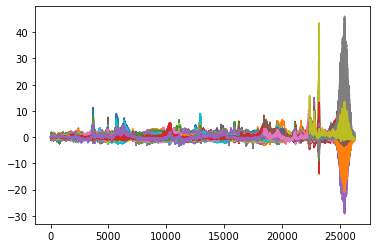

In [251]:
#for key in df.keys().drop(['Datetime']):
key = "mean_chla_depth"
#key = "mean_condF"
lag = 1


idx = target_cols.index(key)
ctx = config['context_points']
lag -=1


plt.plot(dset.train_data[key])
plt.plot(dset.val_data[key])
plt.plot(dset.test_data[key])

plt.plot((dset.train_data[key].index+(lag+ctx)*time_res)[:len(pred_training)],pred_training[:,lag,idx])
plt.plot((dset.val_data[key].index+(lag+ctx)*time_res)[:len(pred_val)],pred_val[:,lag,idx])
plt.plot((dset.test_data[key].index+(lag+ctx)*time_res)[:len(pred_test)],pred_test[:,lag,idx])



lag+=14
plt.plot((dset.train_data[key].index+(lag+ctx)*time_res)[:len(pred_training)],pred_training[:,lag,idx])
plt.plot((dset.val_data[key].index+(lag+ctx)*time_res)[:len(pred_val)],pred_val[:,lag,idx])
plt.plot((dset.test_data[key].index+(lag+ctx)*time_res)[:len(pred_test)],pred_test[:,lag,idx])



plt.show()

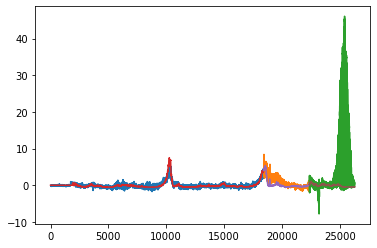

In [273]:
#for prediction:
key = 'diatom'
idx = target_cols.index(key)
ctx = config['context_points']
plt.plot((dset.train_data[key].index+(ctx)*time_res)[:len(pred_training)],pred_training[:,0,0,idx])
plt.plot((dset.val_data[key].index+(ctx)*time_res)[:len(pred_val)],pred_val[:,0,0,idx])
plt.plot((dset.test_data[key].index+(ctx)*time_res)[:len(pred_test)],pred_test[:,0,0,idx])
plt.plot(dset.train_data[key])
plt.plot(dset.val_data[key])
plt.plot(dset.test_data[key])

In [140]:
max_lag = 24

R2ar = np.zeros((3,max_lag,len(df.keys())-1))
for idx_split,split in enumerate(['train','val','test']):
    if split == 'train':
        data = dset.train_data.reset_index(drop=True).replace(0,np.nan)
        pred = pred_training
    if split == 'val':
        data = dset.val_data.reset_index(drop=True).replace(0,np.nan)
        pred = pred_val
    if split == 'test':
        pred = pred_test
        data = dset.test_data.reset_index(drop=True).replace(0,np.nan)
    data_ar = data.drop(columns=['Datetime']).to_numpy()
    mask = data_ar != 0.
        
    
    for lag in range(max_lag):
        for key in df.keys().drop(['Datetime']):
            idx = target_cols.index(key)
            lag
            R2 = (1-np.mean(np.square(mask[(ctx+lag)*time_res:-(trg-lag)*time_res,idx]*(data[key][(ctx+lag)*time_res:-(trg-lag)*time_res]-pred[:,lag,idx].numpy())))/
                    np.mean(np.square(mask[(ctx+lag)*time_res:-(trg-lag)*time_res,idx]*(data[key][(ctx+lag)*time_res:-(trg-lag)*time_res]-data[key][(ctx+lag)*time_res:-(trg-lag)*time_res].mean()))))
            R2ar[idx_split,lag,idx]=R2

IndexError: too many indices for tensor of dimension 2

In [27]:
mask[ctx*time_res:,idx].shape

(3922,)

In [28]:
data[key][ctx*time_res:].to_numpy().shape

(3922,)

In [29]:
pred[:,:,idx].numpy().shape

(3898, 24)

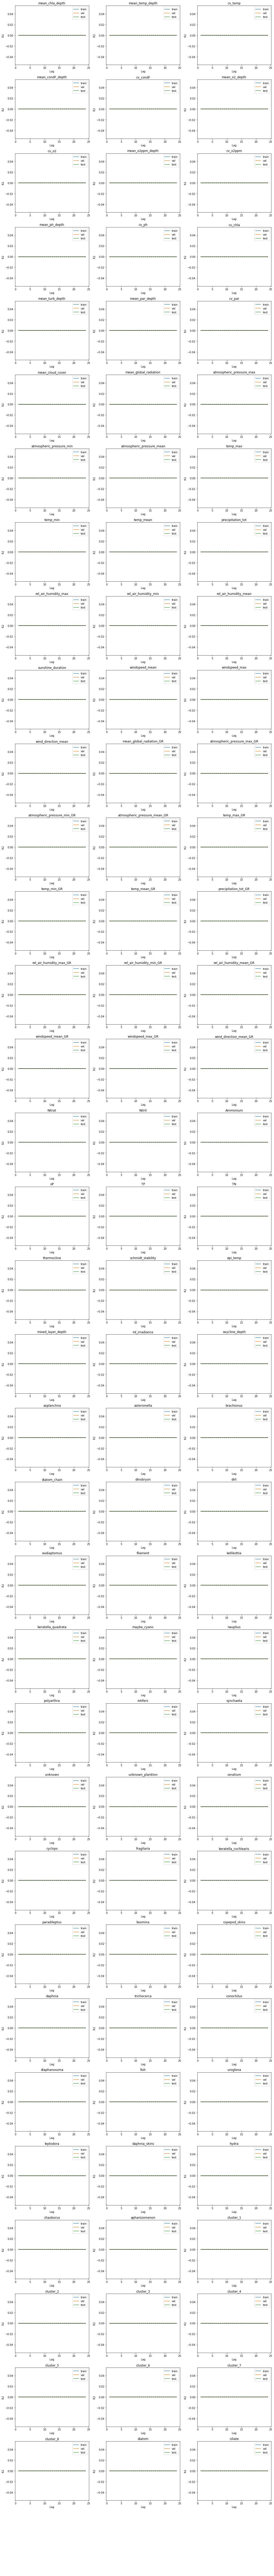

In [267]:
n_plots = len(target_cols)
fig,axt = plt.subplots(1+n_plots//3,3,figsize=(15,4+4*n_plots//3),tight_layout = True)
axs = np.ravel(axt)
for ax,key in zip(axs,target_cols):
    idx = target_cols.index(key)
    [ax.plot(range(1,max_lag+1),R2ar[idx_split,:,idx]) for idx_split in range(3)]
    ax.legend(['train','val','test'])
    ax.hlines(0,max_lag,1,linestyle='dashed',color='black')
    ax.set_ylabel("R2")
    ax.set_xlabel("Lag")
    ax.set_title(key)
for delete_idx in range(-3+(n_plots)%3,0):
    axt[-1,delete_idx].set_axis_off()
plt.show()

In [68]:
y_pred 
y.shape

torch.Size([3946, 102])

In [31]:
#[idx_split,lag,idx]
np.mean(R2ar[1,:,0])

0.8217052523838904

In [32]:
R2ar.shape

(3, 24, 102)

# Animation

In [33]:
plt_key = 'cluster_2'


fig,ax = plt.subplots(1,1,figsize=(10,6))
lag = 0
idx = target_cols.index(plt_key)
ctx = config['context_points']
time_res = config['time_resolution']
ax.plot(dset.train_data[plt_key])
ax.plot(dset.val_data[plt_key])
ax.plot(dset.test_data[plt_key])

pl_train = ax.plot((dset.train_data[key].index+(lag+ctx)*time_res)[:len(pred_training)],pred_training[:,lag,idx],
                  linewidth = 0.5)
pl_val = ax.plot((dset.val_data[plt_key].index+(lag+ctx)*time_res)[:len(pred_val)],pred_val[:,lag,idx],
                linewidth=0.5)
pl_test = ax.plot((dset.test_data[plt_key].index+(lag+ctx)*time_res)[:len(pred_test)],pred_test[:,lag,idx],
                 linewidth = 0.5)

title = ax.set_title(f"Prediction with a lag of {lag+1} days")
ax.set_xlabel('relative time [hours]')
ax.set_ylabel(f'scaled {plt_key}')
plt.close(fig)

In [34]:
def animate(lag):
    #set_x
    pl_train[0].set_xdata((dset.train_data[key].index+(lag+ctx)*time_res)[:len(pred_training)])
    pl_val[0].set_xdata((dset.val_data[plt_key].index+(lag+ctx)*time_res)[:len(pred_val)])
    pl_test[0].set_xdata((dset.test_data[plt_key].index+(lag+ctx)*time_res)[:len(pred_test)])
    #set_y
    pl_train[0].set_ydata(pred_training[:,lag,idx])
    pl_val[0].set_ydata(pred_val[:,lag,idx])
    pl_test[0].set_ydata(pred_test[:,lag,idx])
    
    
    title.set_text(f"Prediction with a lag of {lag+1} days")
    return [pl_train,pl_val,pl_test,title]
ani = FuncAnimation(
    fig, animate,frames = range(0,15), blit=False, save_count=50)

plt.close(fig)

HTML(ani.to_jshtml())

# Linear model examination:
As the linear model simply learns a relation of the shape:

$\vec{y}(t) = AX+\vec{b}$
Where $X$ is the matrix formed by the vectors $\vec{y}(t-1) ... \vec{y}(t-ctx)$,
One can look at the matrix to find out how important are the old time points

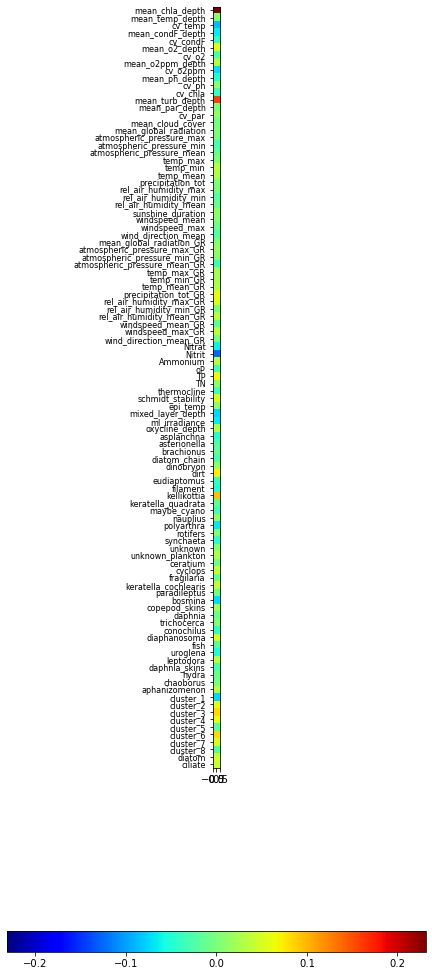

In [262]:
key = 'mean_chla_depth'
idx = target_cols.index(key)
w_idx = forecaster.model.linear.weight.detach()[idx]
mat_idx = torch.cat(w_idx.unsqueeze(0).chunk(len(target_cols),dim=1),dim=0).numpy()
minmax = max(abs(np.min(mat_idx)),np.max(mat_idx))
fig,ax = plt.subplots(1,figsize=(15,20))
img = ax.imshow(mat_idx,cmap='jet',vmin=-minmax,vmax=minmax)
ax.set_yticks(range(len(target_cols)))
ax.set_yticklabels(target_cols, fontsize=8)
plt.colorbar(img,shrink=0.5,orientation='horizontal')

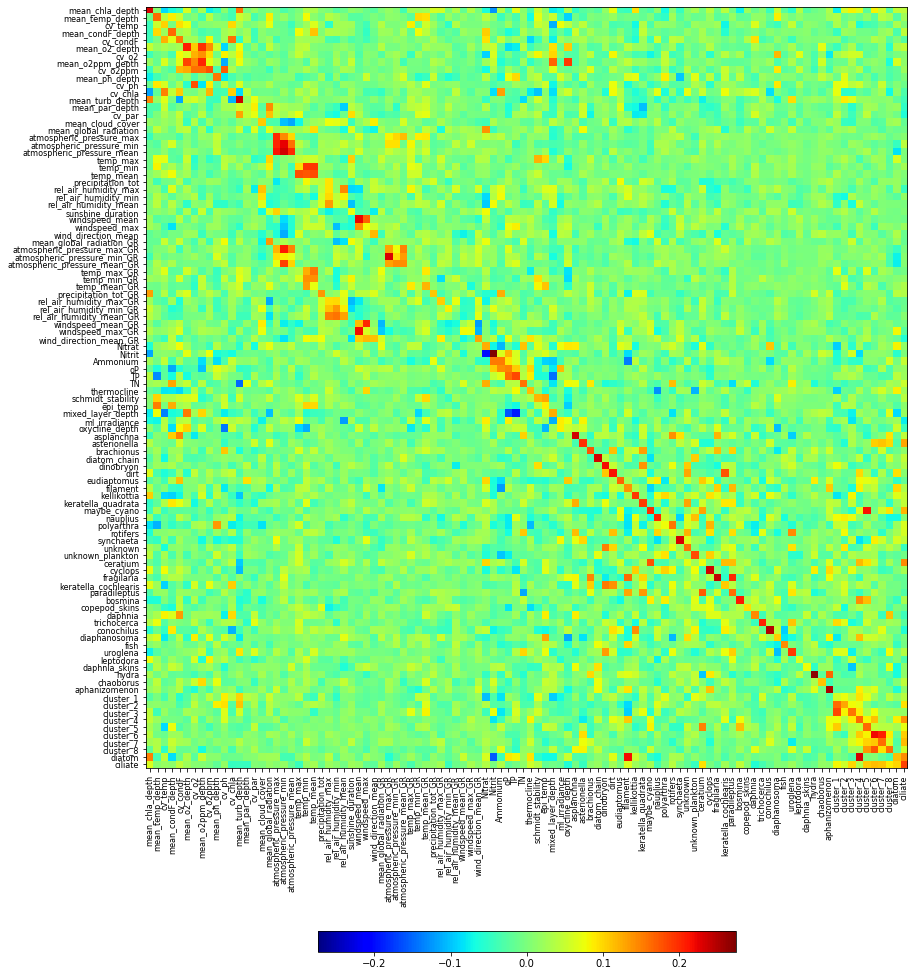

In [265]:
#all key for the latest measurement
idx = target_cols.index(key)
mat_w = forecaster.model.linear.weight.detach().numpy()
minmax = max(abs(np.min(mat_w)),np.max(mat_w))
fig,ax = plt.subplots(1,figsize=(15,20))
img = ax.imshow(mat_w,cmap='jet',vmin=-minmax,vmax=minmax)
ax.set_yticks(range(len(target_cols)))
ax.set_yticklabels(target_cols, fontsize=8)
ax.set_xticks(range(len(target_cols)))
ax.set_xticklabels(target_cols, fontsize=8,rotation = 90)
plt.colorbar(img,shrink=0.5,orientation='horizontal')

In [60]:
mat_idx.shape

torch.Size([1, 2448])

# Attention matrix:


In [30]:
forecaster.eval_step_forward_kwargs['output_attn'] = True

In [64]:
idx = 150
ctx = config['context_points']
trg = config['target_points']
x = torch.tensor(x_train.values,dtype=torch.float32)
y = torch.tensor(y_train.values,dtype=torch.float32)
res_idx,(logist,labels),attention_mat=forecaster.forward_model_pass(x[idx:idx+ctx].unsqueeze(0),
                              y[idx:idx+ctx].unsqueeze(0),
                              x[idx+ctx:idx+ctx+trg].unsqueeze(0),
                              y[idx+ctx:idx+ctx+trg].unsqueeze(0),
                              output_attn=True)

In [65]:
attn = attention_mat[0][0]

In [66]:
ath.shape

torch.Size([408, 408])

In [67]:
ath = attn[0]

In [68]:
config

{'wandb_version': 1,
 '': "{'model': 'spacetimeformer', 'dset': 'HF_noint', 'data_path': 'auto', 'context_points': 8, 'target_points': 15, 'time_resolution': 24, 'batch_size': 8, 'workers': 0, 'gpus': [0], 'l2_coeff': 0.01, 'learning_rate': 0.0001, 'grad_clip_norm': 0, 'linear_window': 0, 'loss': 'mse', 'loss_w': None, 'start_token_len': 3, 'd_model': 80, 'n_heads': 2, 'enc_layers': 3, 'dec_layers': 3, 'd_ff': 0, 'attn_factor': 5, 'dropout_emb': 0.2, 'dropout_token': 0.0, 'dropout_attn_out': 0.0, 'dropout_qkv': 0.0, 'dropout_ff': 0.3, 'global_self_attn': 'performer', 'global_cross_attn': 'performer', 'local_self_attn': 'performer', 'local_cross_attn': 'performer', 'activation': 'gelu', 'post_norm': False, 'norm': 'batch', 'init_lr': 1e-10, 'base_lr': 5e-05, 'warmup_steps': 0, 'decay_factor': 0.25, 'initial_downsample_convs': 1, 'class_loss_imp': 0.1, 'intermediate_downsample_convs': 0, 'time_emb_dim': 12, 'performer_kernel': 'relu', 'performer_redraw_interval': 125, 'embed_method': 'sp

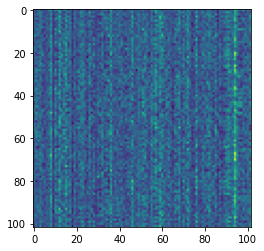

In [69]:
#sum all time steps
ath_s = np.zeros((attn.shape[0],len(target_cols),len(target_cols)))
n_conv = config['initial_downsample_convs']
ctx = config['context_points']
ctx //= 2**(n_conv)
for num_head in range(attn.shape[0]):
    for idx1 in range(len(target_cols)):
        for idx2 in range(len(target_cols)):
            ath_s[num_head,idx1,idx2]=torch.sum(attn[num_head,ctx*idx1:ctx*(idx1+1),ctx*idx2:ctx*(idx2+1)])
plt.imshow(ath_s[0])

In [70]:
#build an adcacency matrix from the sum of all heads:
adj = np.sum(ath_s,axis=0)

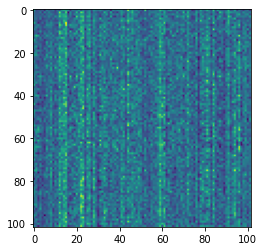

In [71]:
plt.imshow(ath_s[1])

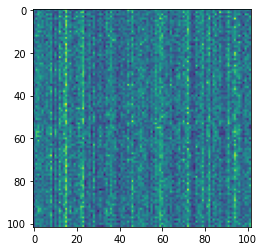

In [54]:
plt.imshow(adj)

In [351]:
#pickle the adjacency matrix to use in the graph notebook
file_att = 'adj_att.pickle'
with open(file_att, 'wb') as f:
    pickle.dump(adj, f)
file_name = 'name.pickle'
with open(file_name, 'wb') as f:
    pickle.dump(target_cols, f)